# Map-based simulation for differential pointing

## Here, we introduce how to assess differential pointing systematics by the map-based simulation in the case of a single detector on the boresight.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scanfields import Field, ScanFields, SignalFields, plot_maps

# Load the cross-link on the boresight detector

## Input map: CMB (r=0), Gaussian beam smoothing (1 deg for FWHM)


In [2]:
# Load single detector map
base_path = "../../crosslinks_2407_3yr/boresight"
scan_field = ScanFields.load_det(base_path, "nside128_boresight.h5")
fiducial_map = hp.read_map("./cmb_0000_nside_128_seed_33.fits", field=(0,1,2)) * 1e6

fwhm = np.deg2rad(1.0)
input_map = hp.smoothing(fiducial_map, fwhm)
nside = hp.npix2nside(len(input_map[0]))
lmax = 3*nside-1
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)

# Set a differential pointing parameter

$\rho$ (`rho`): a magnitude of pointing offset between detector A and B, which makes an orthogonal pair.

$\chi$ (`chi`): a pointing offset direction

Here, we set $(\rho, \chi)=(1,0)$ arcmin differential pointing.


In [3]:
I = input_map[0]
P = input_map[1] + 1j*input_map[2]
dI = hp.alm2map_der1(hp.map2alm(input_map[0]), nside=nside)
dQ = hp.alm2map_der1(hp.map2alm(input_map[1]), nside=nside)
dU = hp.alm2map_der1(hp.map2alm(input_map[2]), nside=nside)

eth_I = dI[2] - dI[1]*1j
eth_P = dQ[2] + dU[1] - (dQ[1] - dU[2])*1j

rho = np.deg2rad(1/60)
chi = np.deg2rad(0)

spin_0_field  = Field(I, spin=0)
spin_1_field  = Field(-rho/2*np.exp(1j*chi)*eth_I, spin=1)
spin_m1_field = spin_1_field.conj()
spin_2_field  = Field(P/2.0, spin=2)
spin_m2_field = spin_2_field.conj()
spin_3_field  = Field(-rho/4*np.exp(1j*chi)*eth_P, spin=3)
spin_m3_field = spin_3_field.conj()

signal_fields = SignalFields(
    spin_0_field,
    spin_1_field,
    spin_m1_field,
    spin_2_field,
    spin_m2_field,
    spin_3_field,
    spin_m3_field,
)

# Solve the liner system

Detailed discription coming soon...

Here, we perform the map-making by 3x3 matrix.


In [4]:
mdim = 3
output_map = scan_field.map_make(signal_fields, mdim=mdim)
residual = input_map - output_map

# Let's check the Input/Output/Residual maps

Especially, we can see that the residual map (Q and U) which is reconstructed by 3x3 noise covariant matrix are contaminated by the systematics


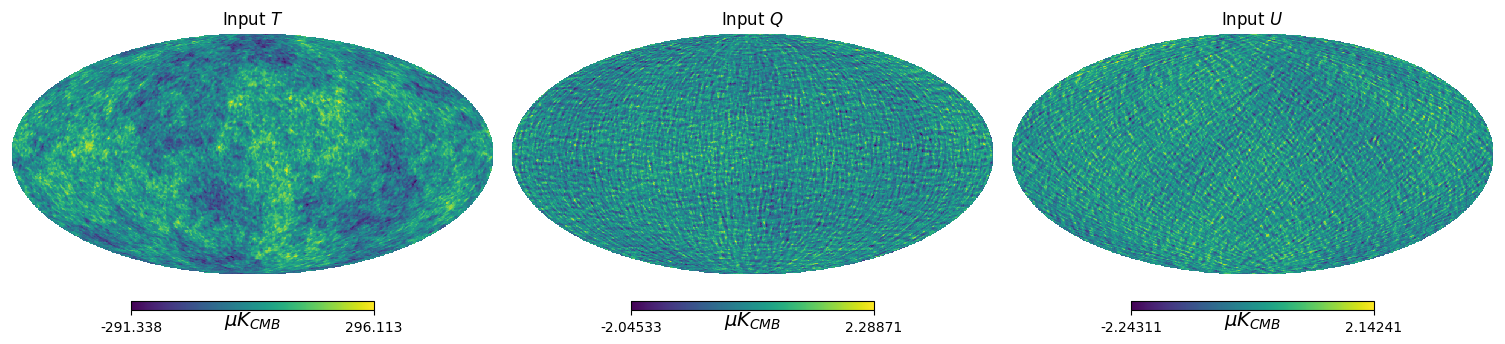

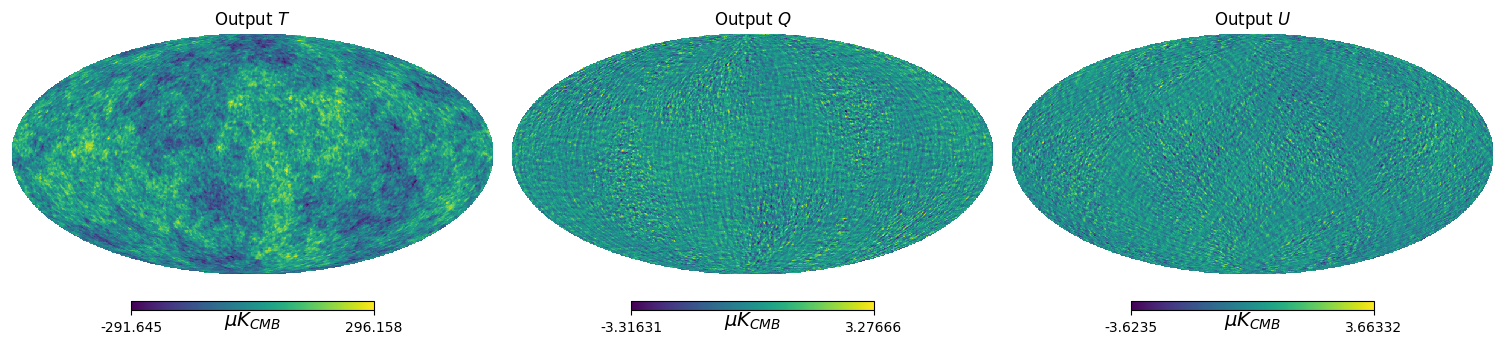

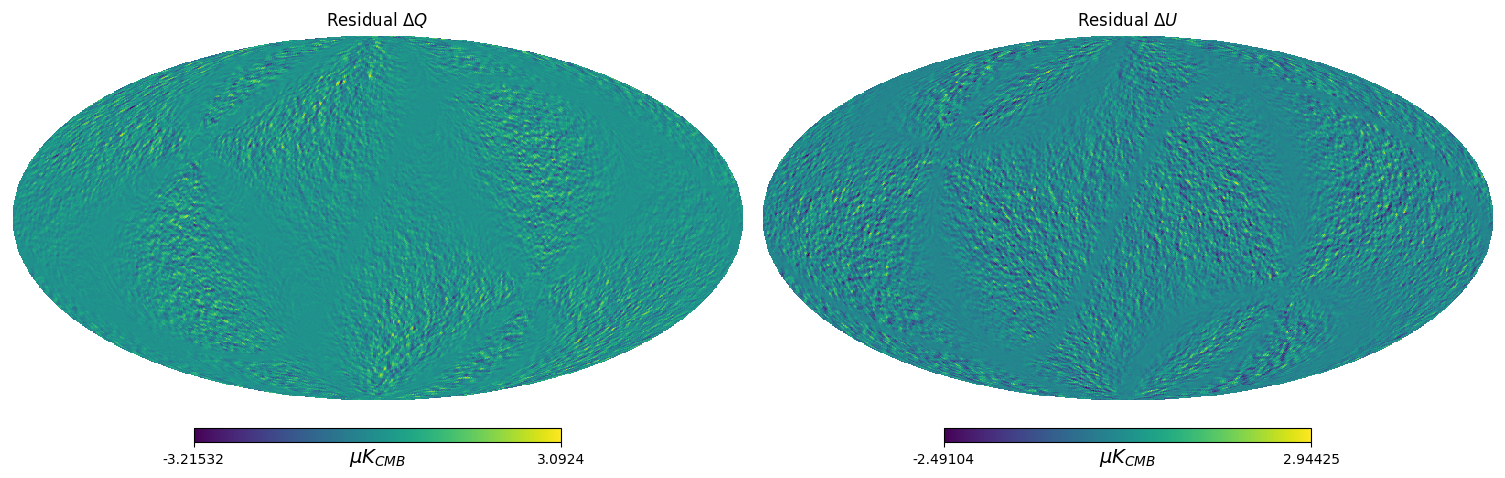

In [5]:
plot_maps(mdim, input_map, output_map, residual)

# Let's check the power spectra

The green line shows systematics power spectrum, i.e., $\Delta C_\ell^{BB}$, which is obtained by residual map.

Althogh the green line is providing an exact solution which agrees with the binning map-making, we can perform an analitical estimation without doing the map-making.

The red line $\Delta C_{\ell, Ana}^{BB}$ is simulated by

$$
\Delta C_{\ell, Ana}^{BB} = (\langle|{}_{1}\tilde{h}|^2\rangle + \langle|{}_{3}\tilde{h}|^2\rangle)~\rho^2~\ell^2~C_{\ell}^{TT}
$$

where $\langle|{}_{n}\tilde{h}|^2\rangle$ represents the entire sky average of the spin-n cross-link (See [C.G.R. Wallis et al.](https://arxiv.org/abs/1604.02290)).


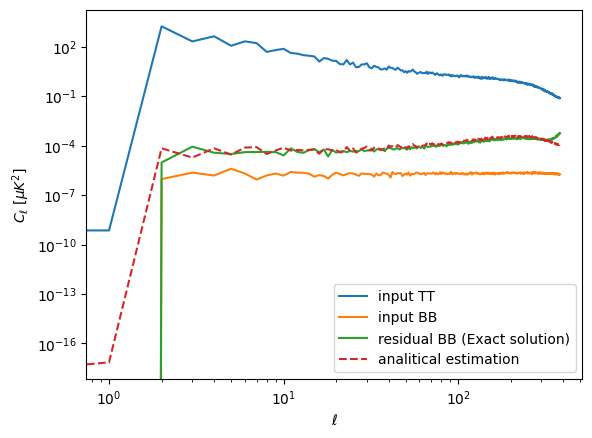

In [6]:
fiducial_cl = hp.anafast(fiducial_map)
res_cl = hp.anafast(residual)

ell = np.arange(len(fiducial_cl[0]))
xlink1_mean = np.mean(np.abs(scan_field.get_xlink(1))**2)
xlink3_mean = np.mean(np.abs(scan_field.get_xlink(2))**2)

ana = (xlink1_mean + xlink3_mean) * fiducial_cl[0] * rho**2 * ell**2

plt.plot(fiducial_cl[0], label="input TT")
plt.plot(fiducial_cl[2], label="input BB")
plt.plot(res_cl[2] / bl[:,2]**2, label="residual BB (Exact solution)") # deconvolution
plt.plot(ana, "--", label="analitical estimation")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();